<a href="https://colab.research.google.com/github/thoongthuck/R-E/blob/main/%EC%A0%95%EB%A0%AC_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy pandas scikit-learn matplotlib

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/찐찐VAD파일.xlsx - Sheet1 (1).csv', encoding='utf-8-sig')

Mounted at /content/drive


# BuNN 알고리즘

/tmp/ipython-input-362230192.py:305: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-362230192.py:305: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-362230192.py:305: UserWarning: Glyph 45236 (\N{HANGUL SYLLABLE NAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-362230192.py:305: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-362230192.py:305: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-362230192.py:305: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-362230192.py:305: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layou

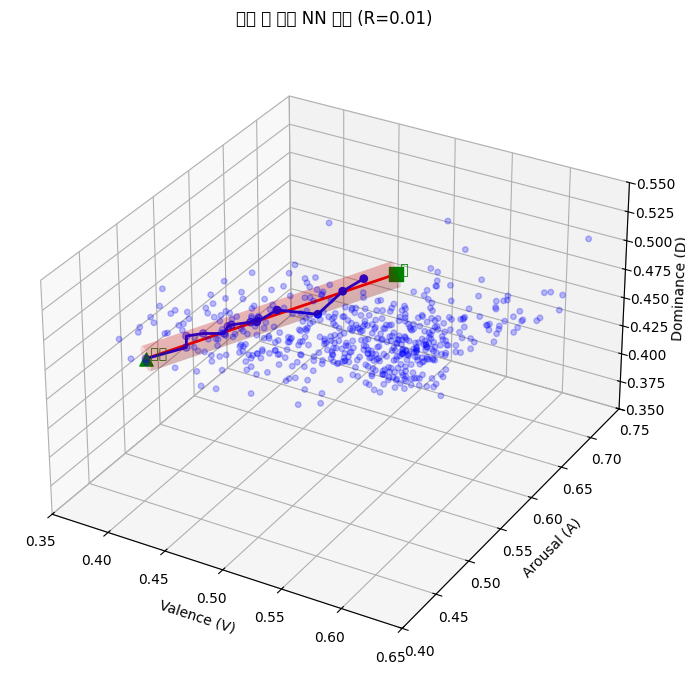

[요약] 시작 index: 188, 끝 index: 386 (경로는 최종 노드 직전에서 정지)
[요약] 원통 내부 노드 수: 17
[요약] 경로 노드 수: 14 / 선분 수: 13

[경로 지표]
- 평균 스텝 크기: 0.0160
- 최대 스텝 크기: 0.0317
- 스텝 크기 표준편차: 0.0083
- 평균 곡률: 1.0251 rad  (58.7361°)
- 방향성 효율(평균 진행량; 타깃 방향 투영): 0.0137
- 방향 정렬도 평균(cos): 0.7932  [-1~1]
- 총 투영도(progress 합): 0.1783
- 총 경로 길이(스텝 길이 합): 0.2082
- 정규화 방향 효율(총 투영도/총 길이): 0.8566

[경로 노드 (title - artist @ V,A,D)]
 1. 너에게로 또 다시 - 이소라  (V=0.388, A=0.476, D=0.458)
 2. 허락되지 않은 사랑 - 이현우  (V=0.414, A=0.492, D=0.467)
 3. Again To Me - 차태현  (V=0.412, A=0.495, D=0.475)
 4. 모르나요 - 차태현  (V=0.424, A=0.500, D=0.477)
 5. 난치병 - 하림  (V=0.437, A=0.508, D=0.477)
 6. 은영이에게 - KCM  (V=0.438, A=0.511, D=0.482)
 7. 니 생각 - 투개월  (V=0.443, A=0.509, D=0.486)
 8. 머릿속에서 니가 막 걸어다녀 - 조은  (V=0.455, A=0.516, D=0.488)
 9. 창문을 열어놓고 - 별  (V=0.458, A=0.523, D=0.489)
10. 그라데이션 - 10CM  (V=0.464, A=0.511, D=0.493)
11. Who Are You - 샘김 (Sam Kim)  (V=0.476, A=0.519, D=0.503)
12. 길 - god  (V=0.502, A=0.535, D=0.499)
13. How You Like That - BLACKPINK  (V=

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


#한글 폰트 자동 설정
def set_korean_font():
    import matplotlib
    from matplotlib import font_manager, rcParams
    candidates = [
        "Malgun Gothic",
        "AppleGothic",
        "NanumGothic"
    ]
    avail = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in avail:
            rcParams["font.family"] = name
            break
    rcParams["axes.unicode_minus"] = False  # 마이너스 부호 깨짐 방지
set_korean_font()

# 설정
RADIUS = 0.01   # 이거는 노드수 보면서 조절
SAVE_FIG_PATH = "monotone_cylinder_nn_path.png"
EPS_T = 1e-9    # 축 방향 전진 판정에 쓰는 작은 여유값

# 시작, 끝 지정 (좌표를 넣으면 가장 가까운 노드로 스냅)
START_INDEX = 0
start_node   = (0.4, 0.4, 0.37)      # 여기에 처음 노드값 넣으면 됨
END_INDEX   = 0
end_node     = (0.55,  0.55, 0.55)     # 여기에 마지막 노드값 넣으면 됨

# 시각화 축 범위 설정
V_MIN, V_MAX = 0.35, 0.65
A_MIN, A_MAX = 0.4, 0.75
D_MIN, D_MAX = 0.35, 0.55

# 유틸, 전처리
def find_vad_columns(df):
    cand = {"V":["v","val","valence"], "A":["a","aro","arousal"], "D":["d","dom","dominance"]}
    found = {}
    for k, names in cand.items():
        hit = None
        for name in names:
            exact  = [c for c in df.columns if c.lower()==name]
            starts = [c for c in df.columns if c.lower().startswith(name)]
            if exact:  hit = exact[0]; break
            if starts: hit = starts[0]; break
        if hit is None:
            raise ValueError(f"'{k}' 컬럼을 찾지 못했습니다. df.columns={list(df.columns)}")
        found[k] = hit
    return found["V"], found["A"], found["D"]

def find_meta_column(df, candidates):
    for name in candidates:
        exact  = [c for c in df.columns if c.lower()==name]
        starts = [c for c in df.columns if c.lower().startswith(name)]
        if exact:  return exact[0]
        if starts: return starts[0]
    return None

def X_from_df(df, cols=("V","A","D")):
    return df.loc[:, list(cols)].to_numpy(float)

def idx_by_coord(X, coord):
    q = np.asarray(coord, float).reshape(1, -1)
    return int(np.argmin(np.linalg.norm(X - q, axis=1)))

def resolve_idx(X, idx, vad):
    if vad is not None:
        # 좌표가 정확히 일치하는 노드가 없어도 가장 가까운 노드로 스냅
        return idx_by_coord(X, vad)
    if idx is not None:
        if not (0 <= idx < len(X)):
            raise ValueError(f"index는 0~{len(X)-1}")
        return int(idx)
    raise ValueError("index 또는 좌표 지정 x")

def finite_cylinder_interior(X, a, b, radius):
    a = np.asarray(a, float); b = np.asarray(b, float)
    axis = b - a
    L = np.linalg.norm(axis)
    if L == 0:
        # 시작=끝이면 내부가 정의 안 됨
        return np.zeros(len(X), dtype=bool), None, None, 0.0, None
    u = axis / L
    ap = X - a
    t = ap @ u                      # 축 방향 좌표
    proj = np.outer(t, u)
    r = np.linalg.norm(ap - proj, axis=1)  # 측면까지의 수직거리
    mask = (t >= 0.0) & (t <= L) & (r <= radius + 1e-12)
    return mask, t, r, L, u

def monotone_nn_path_inside(X, inside_idx, start_idx, end_idx, a, u, eps_t=1e-9):
    t_all = (X - a) @ u
    inside_set = set(int(i) for i in inside_idx)
    remain = [i for i in inside_idx if i not in (start_idx, end_idx)]

    path = [start_idx]
    cur = start_idx
    t_cur = t_all[cur]

    if start_idx == end_idx:
        return path

    while True:
        forward_inside = [i for i in remain if t_all[i] > t_cur + eps_t]
        candidates = list(forward_inside)
        if t_all[end_idx] > t_cur + eps_t:
            candidates_with_end = candidates + [end_idx]
        else:
            candidates_with_end = candidates

        if not candidates_with_end:
            break

        d = np.linalg.norm(X[candidates_with_end] - X[cur], axis=1)
        best = candidates_with_end[int(np.argmin(d))]

        if best == end_idx:
            break

        path.append(best)
        remain.remove(best)
        cur = best
        t_cur = t_all[cur]

    for i in path[1:]:
        assert i in inside_set, f"경로에 내부가 아닌 노드가 포함됨: {i}"

    return path

def cylinder_surface(a, b, radius, n_theta=64, n_len=64):
    a = np.asarray(a, float); b = np.asarray(b, float)
    axis = b - a
    L = np.linalg.norm(axis)
    if L == 0:
        u = np.linspace(0, 2*np.pi, n_theta)
        v = np.linspace(0, np.pi, n_len)
        Xs = a[0] + radius * np.outer(np.cos(u), np.sin(v))
        Ys = a[1] + radius * np.outer(np.sin(u), np.cos(v))
        Zs = a[2] + radius * np.outer(np.ones_like(u), np.cos(v))
        return Xs, Ys, Zs
    u = axis / L
    ref = np.array([1.0,0,0]) if abs(u[0]) < 0.9 else np.array([0,1.0,0])
    v = np.cross(u, ref); v /= np.linalg.norm(v)
    w = np.cross(u, v)
    thetas = np.linspace(0, 2*np.pi, n_theta)
    ts = np.linspace(0, L, n_len)
    ct, st = np.cos(thetas), np.sin(thetas)
    Xs = np.zeros((n_len, n_theta)); Ys = np.zeros_like(Xs); Zs = np.zeros_like(Xs)
    for i, t in enumerate(ts):
        center = a + u*t
        ring = np.outer(ct, v) + np.outer(st, w)
        ring = center + radius * ring
        Xs[i,:], Ys[i,:], Zs[i,:] = ring[:,0], ring[:,1], ring[:,2]
    return Xs, Ys, Zs

def compute_path_metrics(X, path_idx, target_point, eps=1e-12):
    P = X[path_idx]
    m = len(P)
    if m < 2:
        return {
            "step_len_mean": None, "step_len_max": None, "step_len_std": None,
            "curvature_mean_rad": None, "curvature_mean_deg": None,
            "progress_mean": None, "align_mean": None,
            "progress_sum": None, "path_len_total": None, "dir_efficiency": None,
        }

    diffs = np.diff(P, axis=0)
    step_len = np.linalg.norm(diffs, axis=1)

    curv_list = []
    for i in range(len(diffs)-1):
        a_ = diffs[i]; b_ = diffs[i+1]
        na = np.linalg.norm(a_); nb = np.linalg.norm(b_)
        if na < eps or nb < eps:
            continue
        cosang = np.clip(np.dot(a_, b_)/(na*nb), -1.0, 1.0)
        theta = np.arccos(cosang)
        curv_list.append(theta)
    curvature_mean_rad = float(np.mean(curv_list)) if curv_list else None
    curvature_mean_deg = float(np.degrees(curvature_mean_rad)) if curvature_mean_rad is not None else None

    progress_vals, align_vals = [], []
    for i in range(m-1):
        vt = P[i+1] - P[i]
        ut = target_point - P[i]
        nu = np.linalg.norm(ut)
        nv = np.linalg.norm(vt)
        if nu < eps:
            continue
        uhat = ut / nu
        progress_vals.append(float(np.dot(vt, uhat)))
        if nv > eps:
            align_vals.append(float(np.dot(vt/nv, uhat)))
    progress_mean   = float(np.mean(progress_vals)) if progress_vals else None
    align_mean      = float(np.mean(align_vals))  if align_vals  else None
    progress_sum    = float(np.sum(progress_vals)) if progress_vals else None
    path_len_total  = float(np.sum(step_len)) if len(step_len) else None
    dir_efficiency  = (progress_sum / path_len_total) if (progress_sum is not None and path_len_total and path_len_total > eps) else None

    return {
        "step_len_mean": float(np.mean(step_len)),
        "step_len_max":  float(np.max(step_len)),
        "step_len_std":  float(np.std(step_len)),
        "curvature_mean_rad": curvature_mean_rad,
        "curvature_mean_deg": curvature_mean_deg,
        "progress_mean": progress_mean,
        "align_mean": align_mean,
        "progress_sum": progress_sum,
        "path_len_total": path_len_total,
        "dir_efficiency": dir_efficiency,
    }

# 실행

# V/A/D 컬럼 자동 탐색
vcol, acol, dcol = find_vad_columns(df)

# title/artist 컬럼 자동 탐색(한글 후보 포함)
title_col  = find_meta_column(df, ["title", "곡명", "track", "song", "name"])
artist_col = find_meta_column(df, ["artist", "가수", "singer", "performer"])

X = X_from_df(df, cols=(vcol, acol, dcol))
s = resolve_idx(X, START_INDEX, start_node)

t = resolve_idx(X, END_INDEX,   end_node)
a, b = X[s], X[t]

# 원통 내부 노드만 선별
inside_mask, t_all, r_all, L, u = finite_cylinder_interior(X, a, b, RADIUS)
inside_idx = np.where(inside_mask)[0]

# 축 방향으로만 전진 제약을 둔 NN 경로
path_idx = monotone_nn_path_inside(X, inside_idx, s, t, a, u, eps_t=EPS_T)

# 시각화
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection="3d")

# 기준 직선(빨강) + 원통(투명 빨강)
ax.plot([a[0], b[0]], [a[1], b[1]], [a[2], b[2]], c="red", linewidth=2)
Xs, Ys, Zs = cylinder_surface(a, b, RADIUS, n_theta=64, n_len=64)
ax.plot_surface(Xs, Ys, Zs, alpha=0.15, color="red", linewidth=0, shade=True)

# 경로에 포함되지 않은 노드
path_set = set(path_idx)
outside_idx = np.where(~inside_mask)[0]
rest_inside_idx  = [i for i in inside_idx if i not in path_set]
rest_outside_idx = [i for i in outside_idx if i not in path_set]

if len(rest_inside_idx) > 0:
    rest_in = X[rest_inside_idx]
    ax.scatter(rest_in[:,0], rest_in[:,1], rest_in[:,2], s=16, c="blue", alpha=0.25)

if len(rest_outside_idx) > 0:
    rest_out = X[rest_outside_idx]
    ax.scatter(rest_out[:,0], rest_out[:,1], rest_out[:,2], s=16, c="blue", alpha=0.25)

# 경로에 실제로 사용된 내부 노드: 불투명, 더 크게
path_xyz = X[path_idx]
ax.plot(path_xyz[:,0], path_xyz[:,1], path_xyz[:,2], c="blue", linewidth=2)
ax.scatter(path_xyz[:,0], path_xyz[:,1], path_xyz[:,2], s=28, c="blue")  # alpha=1 (기본)

# 시작/끝 마커
ax.scatter(a[0], a[1], a[2], s=90, c="green", marker="^"); ax.text(a[0], a[1], a[2], " 시작", color="green")
ax.scatter(b[0], b[1], b[2], s=90, c="green", marker="s"); ax.text(b[0], b[1], b[2], " 끝", color="green")

# 축 범위 + 정육면체 비율
ax.set_xlabel("Valence (V)")
ax.set_ylabel("Arousal (A)")
ax.set_zlabel("Dominance (D)")
ax.set_xlim(V_MIN, V_MAX); ax.set_ylim(A_MIN, A_MAX); ax.set_zlim(D_MIN, D_MAX)
ax.set_box_aspect((V_MAX - V_MIN, A_MAX - A_MIN, D_MAX - D_MIN))
ax.set_title(f"원통 내 단조 NN 경로 (R={RADIUS})")

plt.tight_layout()
plt.savefig(SAVE_FIG_PATH, dpi=150)
plt.show()


#  요약 + 지표
print(f"[요약] 시작 index: {s}, 끝 index: {t} (경로는 최종 노드 직전에서 정지)")
print(f"[요약] 원통 내부 노드 수: {len(inside_idx)}")
print(f"[요약] 경로 노드 수: {len(path_idx)} / 선분 수: {max(0, len(path_idx)-1)}")

metrics = compute_path_metrics(X, path_idx, target_point=b, eps=1e-12)

def _fmt(x, nd=4):
    return "N/A" if x is None else f"{x:.{nd}f}"

print("\n[경로 지표]")
print(f"- 평균 스텝 크기: {_fmt(metrics['step_len_mean'])}")
print(f"- 최대 스텝 크기: {_fmt(metrics['step_len_max'])}")
print(f"- 스텝 크기 표준편차: {_fmt(metrics['step_len_std'])}")
print(f"- 평균 곡률: {_fmt(metrics['curvature_mean_rad'])} rad  ({_fmt(metrics['curvature_mean_deg'])}°)")
print(f"- 방향성 효율(평균 진행량; 타깃 방향 투영): {_fmt(metrics['progress_mean'])}")
print(f"- 방향 정렬도 평균(cos): {_fmt(metrics['align_mean'])}  [-1~1]")
print(f"- 총 투영도(progress 합): {_fmt(metrics['progress_sum'])}")
print(f"- 총 경로 길이(스텝 길이 합): {_fmt(metrics['path_len_total'])}")
print(f"- 정규화 방향 효율(총 투영도/총 길이): {_fmt(metrics['dir_efficiency'])}")

print("\n[경로 노드 (title - artist @ V,A,D)]")
for k, idx in enumerate(path_idx, 1):
    row = df.iloc[idx]
    # 한글 컬럼명도 자동 인식
    tname = row[title_col]  if title_col  is not None and title_col  in row else ""
    aname = row[artist_col] if artist_col is not None and artist_col in row else ""
    v, a_, d = row[vcol], row[acol], row[dcol]
    if tname or aname:
        print(f"{k:2d}. {tname} - {aname}  (V={v:.3f}, A={a_:.3f}, D={d:.3f})")
    else:
        print(f"{k:2d}. (V={v:.3f}, A={a_:.3f}, D={d:.3f})")

#A* 알고리즘


✅ 시작곡(스냅): 너에게로 또 다시 (V=0.388, A=0.476, D=0.458)
✅ 목표곡(스냅): 흑백사진 (V=0.549, A=0.568, D=0.530)
✅ 최대 경로 노드 수: 20, 목표 '노드' 중심 구 반경: 0.020

 1. 너에게로 또 다시 - 이소라  (V=0.388, A=0.476, D=0.458)
 2. 허락되지 않은 사랑 - 이현우  (V=0.414, A=0.492, D=0.467)
 3. 난치병 - 하림  (V=0.437, A=0.508, D=0.477)
 4. 머릿속에서 니가 막 걸어다녀 - 조은  (V=0.455, A=0.516, D=0.488)
 5. 12월의 기적 (Miracles In December) - EXO  (V=0.493, A=0.534, D=0.493)
 6. 길 - god  (V=0.502, A=0.535, D=0.499)
 7. How You Like That - BLACKPINK  (V=0.516, A=0.547, D=0.516)
 8. 그 남자 (원곡가수 현빈) - The One (더원)  (V=0.527, A=0.560, D=0.524)
 9. 흑백사진 - KCM  (V=0.549, A=0.568, D=0.530)

[경로: (title, artist)]
 1. 너에게로 또 다시 - 이소라
 2. 허락되지 않은 사랑 - 이현우
 3. 난치병 - 하림
 4. 머릿속에서 니가 막 걸어다녀 - 조은
 5. 12월의 기적 (Miracles In December) - EXO
 6. 길 - god
 7. How You Like That - BLACKPINK
 8. 그 남자 (원곡가수 현빈) - The One (더원)
 9. 흑백사진 - KCM

[요약]
- 거쳐간 노드 수: 9
- 총 경로 길이: 0.2057
- 선분 수: 8

[경로 지표]
- 평균 스텝 크기: 0.0257
- 최대 스텝 크기: 0.0417
- 스텝 크기 표준편차: 0.0086
- 평균 곡률: 0.3752 rad  (21.4949°)
- 

/tmp/ipython-input-692334627.py:293: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-692334627.py:293: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-692334627.py:293: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-692334627.py:293: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-692334627.py:293: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-692334627.py:293: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-692334627.py:293: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipy

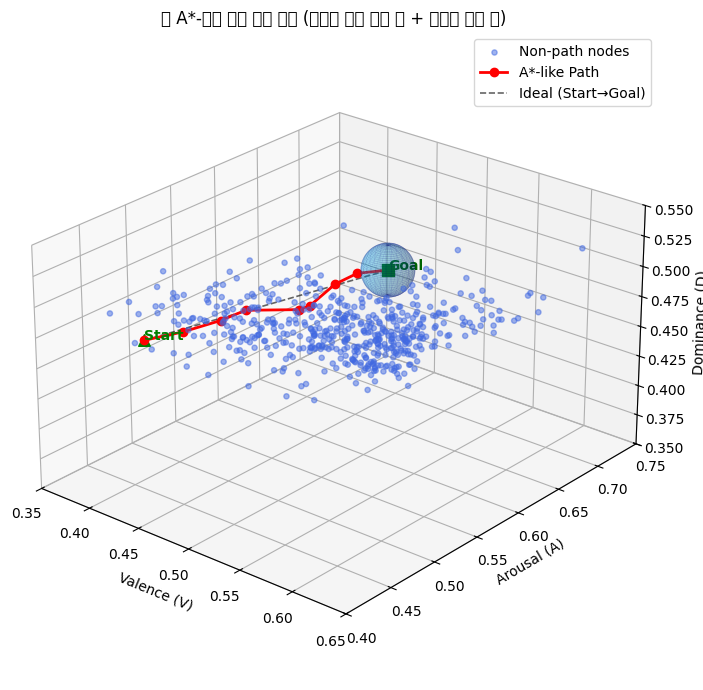

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 사용자 설정
CSV_PATH = "VAD_song (1).csv"   # CSV 파일 경로
START_VAD = (0.4, 0.4, 0.37)   # 시작 VAD 좌표(0~1)
GOAL_VAD  = (0.55, 0.55, 0.55)    # 목표 VAD 좌표(0~1)
N_STEPS   = 20                      # 최대 경로 길이(노드 수 상한)
DISTANCE_THRESHOLD = 0.02           # 목표 '노드' 중심 구 반경

# A*-like 가중치
ALPHA = 0.6   # 누적거리 가중치
BETA  = 0.3   # 목표까지의 휴리스틱 거리 가중치
GAMMA = 0.1   # 목표방향 정렬(코사인) 보상 가중치

INVERT_V = True
INVERT_A = True
INVERT_D = False

AX_V_LIM = (0.35, 0.65)
AX_A_LIM = (0.4, 0.75)
AX_D_LIM = (0.35, 0.55)

# 메타 컬럼 자동 탐색
def find_meta_column(df, candidates):
    cols_lower = {str(c).lower(): c for c in df.columns}
    for name in candidates:
        if name in cols_lower:
            return cols_lower[name]
        for k, orig in cols_lower.items():
            if k.startswith(name):
                return orig
    return None

# 데이터 로드
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

# title / artist 컬럼 인식
TITLE_COL  = find_meta_column(df, ["title","곡명","track","song","name"])
ARTIST_COL = find_meta_column(df, ["artist","가수","singer","performer","artist_name"])

songs = df.to_dict(orient="records")

# 유틸
def distance(a, b):
    return math.sqrt((a["V"] - b["V"])**2 + (a["A"] - b["A"])**2 + (a["D"] - b["D"])**2)

def direction_similarity(current, candidate, goal):
    v1 = np.array([candidate["V"]-current["V"], candidate["A"]-current["A"], candidate["D"]-current["D"]], float)
    v2 = np.array([goal["V"]-current["V"],     goal["A"]-current["A"],     goal["D"]-current["D"]],     float)
    n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
    if n1 == 0 or n2 == 0:
        return 0.0
    return float(np.dot(v1, v2) / (n1 * n2))

def nearest_song_by_vad(vad_tuple):
    target = {"V": float(vad_tuple[0]), "A": float(vad_tuple[1]), "D": float(vad_tuple[2])}
    return min(songs, key=lambda s: distance(s, target))

def vec_of(song):
    return np.array([song["V"], song["A"], song["D"]], dtype=float)

# 시작/목표 좌표를 실제 노드로 스냅
start_song = nearest_song_by_vad(START_VAD)
goal_song  = nearest_song_by_vad(GOAL_VAD)
start_vec  = vec_of(start_song)
goal_vec   = vec_of(goal_song)

# 경로 생성 (A*-like)
def playlist_a_star(songs, start, goal, n, distance_threshold, alpha=0.6, beta=0.3, gamma=0.1):
    unvisited = {i: s for i, s in enumerate(songs) if s is not start}
    path = [start]
    g_cost = {id(start): 0.0}
    current = start

    for _ in range(n-1):
        best_score, best_song = float("inf"), None
        for s in unvisited.values():
            g = g_cost[id(current)] + distance(current, s)
            h = distance(s, goal)
            dir_sim = direction_similarity(current, s, goal)
            f = alpha * g + beta * h - gamma * dir_sim
            if f < best_score:
                best_score, best_song = f, s

        if best_song is None:
            break

        path.append(best_song)
        g_cost[id(best_song)] = g_cost[id(current)] + distance(current, best_song)
        current = best_song

        if distance(current, goal) < distance_threshold:
            break

        del unvisited[list(unvisited.keys())[list(unvisited.values()).index(best_song)]]

    if goal not in path:
        path.append(goal)
    return path

playlist = playlist_a_star(
    songs, start=start_song, goal=goal_song, n=N_STEPS,
    distance_threshold=DISTANCE_THRESHOLD, alpha=ALPHA, beta=BETA, gamma=GAMMA
)

# 경로/지표 계산
def compute_path_metrics_from_playlist(playlist, target_vec, eps=1e-12):
    P = np.array([[s["V"], s["A"], s["D"]] for s in playlist], dtype=float)
    m = len(P)
    if m < 2:
        return {
            "step_len_mean": None, "step_len_max": None, "step_len_std": None,
            "curvature_mean_rad": None, "curvature_mean_deg": None,
            "progress_mean": None, "align_mean": None,
            "progress_sum": None, "path_len_total": None, "dir_efficiency": None,
        }
    diffs = np.diff(P, axis=0)
    step_len = np.linalg.norm(diffs, axis=1)
    curv_list = []
    for i in range(len(diffs)-1):
        a = diffs[i]; b = diffs[i+1]
        na = np.linalg.norm(a); nb = np.linalg.norm(b)
        if na < eps or nb < eps: continue
        cosang = float(np.clip(np.dot(a, b)/(na*nb), -1.0, 1.0))
        curv_list.append(math.acos(cosang))
    curvature_mean_rad = float(np.mean(curv_list)) if curv_list else None
    curvature_mean_deg = float(np.degrees(curvature_mean_rad)) if curvature_mean_rad is not None else None

    progress_vals, align_vals = [], []
    for i in range(m-1):
        vt = P[i+1] - P[i]
        ut = target_vec - P[i]
        nu = float(np.linalg.norm(ut))
        nv = float(np.linalg.norm(vt))
        if nu < eps: continue
        uhat = ut / nu
        progress_vals.append(float(np.dot(vt, uhat)))
        if nv > eps: align_vals.append(float(np.dot(vt/nv, uhat)))
    progress_mean   = float(np.mean(progress_vals)) if progress_vals else None
    align_mean      = float(np.mean(align_vals))  if align_vals  else None
    progress_sum    = float(np.sum(progress_vals)) if progress_vals else None
    path_len_total  = float(np.sum(step_len)) if len(step_len) else None
    dir_efficiency  = (progress_sum / path_len_total) if (progress_sum is not None and path_len_total and path_len_total > eps) else None

    return {
        "step_len_mean": float(np.mean(step_len)),
        "step_len_max":  float(np.max(step_len)),
        "step_len_std":  float(np.std(step_len)),
        "curvature_mean_rad": curvature_mean_rad,
        "curvature_mean_deg": curvature_mean_deg,
        "progress_mean": progress_mean,
        "align_mean": align_mean,
        "progress_sum": progress_sum,
        "path_len_total": path_len_total,
        "dir_efficiency": dir_efficiency,
    }

# 출력
def _safe_str(x):
    return "" if x is None or (isinstance(x, float) and np.isnan(x)) else str(x)

print(f"시작곡: {_safe_str(start_song.get(TITLE_COL))} "
      f"(V={start_song['V']:.3f}, A={start_song['A']:.3f}, D={start_song['D']:.3f})")
print(f"목표곡: {_safe_str(goal_song.get(TITLE_COL))} "
      f"(V={goal_song['V']:.3f}, A={goal_song['A']:.3f}, D={goal_song['D']:.3f})")
print(f"최대 경로 노드 수: {N_STEPS}, 목표 중심 구 반경: {DISTANCE_THRESHOLD:.3f}\n")

for i, s in enumerate(playlist, 1):
    ti = _safe_str(s.get(TITLE_COL))
    ar = _safe_str(s.get(ARTIST_COL))
    print(f"{i:2d}. {ti} - {ar}  (V={s['V']:.3f}, A={s['A']:.3f}, D={s['D']:.3f})")

# 경로 title/artist 리스트 출력
titles_artists = [(_safe_str(s.get(TITLE_COL)), _safe_str(s.get(ARTIST_COL))) for s in playlist]
print("\n[경로: (title, artist)]")
for i, (ti, ar) in enumerate(titles_artists, 1):
    print(f"{i:2d}. {ti} - {ar}")

# 경로 길이
P = np.array([[s["V"], s["A"], s["D"]] for s in playlist], dtype=float)
path_len = float(np.sum(np.linalg.norm(np.diff(P, axis=0), axis=1))) if len(P) >= 2 else 0.0

print("\n")
print(f"- 거쳐간 노드 수: {len(playlist)}")
print(f"- 총 경로 길이: {path_len:.4f}")
print(f"- 선분 수: {max(0, len(playlist)-1)}")

# 경로 지표
metrics = compute_path_metrics_from_playlist(playlist, target_vec=goal_vec, eps=1e-12)
def _fmt(x, nd=4): return "N/A" if x is None else f"{x:.{nd}f}"

print("\n")
print(f"- 평균 스텝 크기: {_fmt(metrics['step_len_mean'])}")
print(f"- 최대 스텝 크기: {_fmt(metrics['step_len_max'])}")
print(f"- 스텝 크기 표준편차: {_fmt(metrics['step_len_std'])}")
print(f"- 평균 곡률: {_fmt(metrics['curvature_mean_rad'])} rad  ({_fmt(metrics['curvature_mean_deg'])}°)")
print(f"- 방향성 효율(평균 진행량; 타깃 방향 투영): {_fmt(metrics['progress_mean'])}")
print(f"- 방향 정렬도 평균(cos): {_fmt(metrics['align_mean'])}  [-1~1]")
print(f"- 총 투영도(progress 합): {_fmt(metrics['progress_sum'])}")
print(f"- 총 경로 길이(스텝 길이 합): {_fmt(metrics['path_len_total'])}")
print(f"- 정규화 방향 효율(총 투영도/총 길이): {_fmt(metrics['dir_efficiency'])}")

# 축 범위 적용 헬퍼
def apply_axis_limits(ax, invert_v, invert_a, invert_d, v_lim, a_lim, d_lim):
    # V
    if v_lim is not None:
        ax.set_xlim(v_lim[0], v_lim[1])
    else:
        ax.set_xlim(1, 0) if invert_v else ax.set_xlim(0, 1)
    # A
    if a_lim is not None:
        ax.set_ylim(a_lim[0], a_lim[1])
    else:
        ax.set_ylim(1, 0) if invert_a else ax.set_ylim(0, 1)
    # D
    if d_lim is not None:
        ax.set_zlim(d_lim[0], d_lim[1])
    else:
        ax.set_zlim(1, 0) if invert_d else ax.set_zlim(0, 1)

    # 등축 비율(지정된 범위 기준)
    xr = abs(ax.get_xlim()[1] - ax.get_xlim()[0])
    yr = abs(ax.get_ylim()[1] - ax.get_ylim()[0])
    zr = abs(ax.get_zlim()[1] - ax.get_zlim()[0])
    ax.set_box_aspect((xr, yr, zr))

# 시각화
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection="3d")

# 모든 노드 좌표 배열
X = df[["V","A","D"]].to_numpy(float)

# 경로 노드 인덱스(좌표 근접 매칭)
path_idx = []
for s in playlist:
    p = np.array([s["V"], s["A"], s["D"]], dtype=float)
    idx = int(np.argmin(np.linalg.norm(X - p, axis=1)))
    path_idx.append(idx)
path_idx = np.array(sorted(set(path_idx)))
mask_path = np.zeros(len(X), dtype=bool); mask_path[path_idx] = True

# 비경로 노드
ax.scatter(X[~mask_path,0], X[~mask_path,1], X[~mask_path,2],
           c="royalblue", s=14, alpha=0.5, label="Non-path nodes")

# 경로 노드(빨간 점 + 선)
PV = [s["V"] for s in playlist]
PA = [s["A"] for s in playlist]
PD = [s["D"] for s in playlist]
ax.plot(PV, PA, PD, '-o', color='red', linewidth=2, label="A*-like Path", zorder=3)

# 이상적 직선(시작→목표 노드)
ax.plot([start_vec[0], goal_vec[0]],
        [start_vec[1], goal_vec[1]],
        [start_vec[2], goal_vec[2]],
        '--', color='black', linewidth=1.2, alpha=0.6, label="Ideal (Start→Goal)", zorder=1)

# 시작/끝 마커
ax.scatter(PV[0], PA[0], PD[0], c="green", s=70, marker="^", zorder=4)
ax.text(PV[0], PA[0], PD[0], "Start", color="green", fontsize=10, weight='bold', zorder=4)
ax.scatter(PV[-1], PA[-1], PD[-1], c="darkgreen", s=70, marker="s", zorder=4)
ax.text(PV[-1], PA[-1], PD[-1], "Goal", color="darkgreen", fontsize=10, weight='bold', zorder=4)

# 목표 중심 구
r = DISTANCE_THRESHOLD
u, v = np.mgrid[0:2*np.pi:60j, 0:np.pi:40j]
sx = goal_vec[0] + r * np.cos(u) * np.sin(v)
sy = goal_vec[1] + r * np.sin(u) * np.sin(v)
sz = goal_vec[2] + r * np.cos(v)
ax.plot_surface(sx, sy, sz, color='deepskyblue', alpha=0.20, linewidth=0, shade=True, zorder=0)
ax.plot_wireframe(sx, sy, sz, color='navy', alpha=0.12, linewidth=0.4, zorder=0)

# 축 범위/뒤집기 적용
apply_axis_limits(ax, INVERT_V, INVERT_A, INVERT_D, AX_V_LIM, AX_A_LIM, AX_D_LIM)

if INVERT_V: ax.invert_xaxis()
if INVERT_A: ax.invert_yaxis()
ax.set_xlabel("Valence (V)")
ax.set_ylabel("Arousal (A)")
ax.set_zlabel("Dominance (D)")
ax.set_title("🎧 A*-기반 감정 이동 경로 (목표곡 중심 반경 구 + 사용자 지정 축)")
ax.legend(loc="best")
ax.view_init(elev=25, azim=130)
plt.tight_layout()
plt.show()

#경로 나눔 알고리즘


✅ 시작곡(스냅): 너에게로 또 다시 - 이소라 (V=0.388, A=0.476, D=0.458)
✅ 목표곡(스냅): 흑백사진 - KCM (V=0.549, A=0.568, D=0.530)
✅ 분할 단계: 10, 목표 '노드' 중심 구 반경: 0.020

 1. 너에게로 또 다시 - 이소라  (V=0.388, A=0.476, D=0.458)
 2. 허락되지 않은 사랑 - 이현우  (V=0.414, A=0.492, D=0.467)
 3. 모르나요 - 차태현  (V=0.424, A=0.500, D=0.477)
 4. 니 생각 - 투개월  (V=0.443, A=0.509, D=0.486)
 5. 머릿속에서 니가 막 걸어다녀 - 조은  (V=0.455, A=0.516, D=0.488)
 6. Who Are You - 샘김 (Sam Kim)  (V=0.476, A=0.519, D=0.503)
 7. 길 - god  (V=0.502, A=0.535, D=0.499)
 8. How You Like That - BLACKPINK  (V=0.516, A=0.547, D=0.516)
 9. 그 남자 (원곡가수 현빈) - The One (더원)  (V=0.527, A=0.560, D=0.524)
10. 흑백사진 - KCM  (V=0.549, A=0.568, D=0.530)

[경로: (title, artist)]
 1. 너에게로 또 다시 - 이소라
 2. 허락되지 않은 사랑 - 이현우
 3. 모르나요 - 차태현
 4. 니 생각 - 투개월
 5. 머릿속에서 니가 막 걸어다녀 - 조은
 6. Who Are You - 샘김 (Sam Kim)
 7. 길 - god
 8. How You Like That - BLACKPINK
 9. 그 남자 (원곡가수 현빈) - The One (더원)
10. 흑백사진 - KCM

[요약]
- 거쳐간 노드 수: 10
- 총 경로 길이: 0.2105
- 선분 수: 9

[경로 지표]
- 평균 스텝 크기: 0.0234
- 최대 스텝 크기: 0.0317
- 스텝

/tmp/ipython-input-1767950714.py:270: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1767950714.py:270: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1767950714.py:270: UserWarning: Glyph 54624 (\N{HANGUL SYLLABLE HAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1767950714.py:270: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1767950714.py:270: UserWarning: Glyph 44611 (\N{HANGUL SYLLABLE GIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1767950714.py:270: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1767950714.py:270: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tm

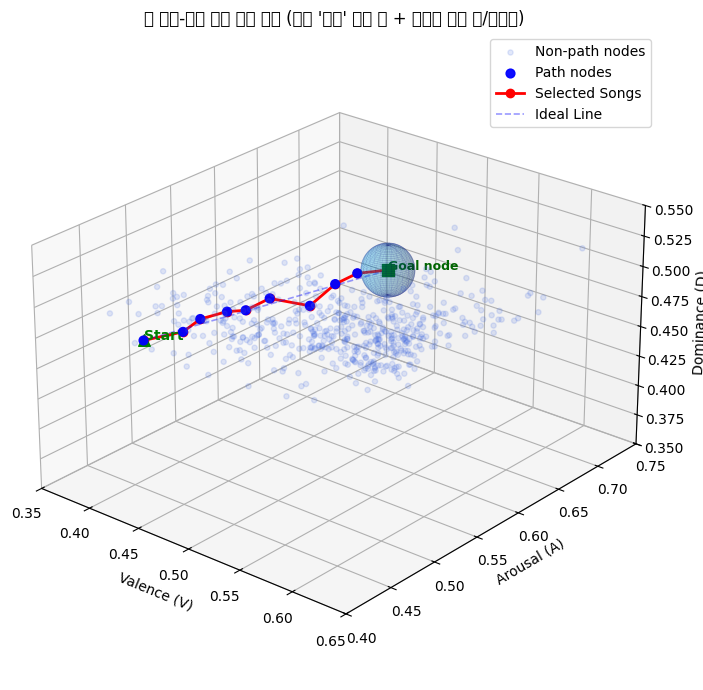

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import os

# 사용자 설정
CSV_PATH = "VAD_song (1).csv"   # CSV 파일 경로
START_VAD = (0.4,0.4, 0.37)    # 시작 VAD 좌표(0~1)
GOAL_VAD  = (0.55,  0.55,  0.55)      # 목표 VAD 좌표(0~1)
N_SEGMENTS = 10                      # 분할 단계 수 (직선 등분 개수)
DISTANCE_THRESHOLD = 0.02             # 목표 '노드' 중심 구 반경(도달 판정)

# 축 뒤집기 토글
INVERT_V = True    # V축 뒤집기
INVERT_A = True    # A축 뒤집기
INVERT_D = False   # D축 뒤집기

# (추가) 축 범위 고정: (min, max); 자동이면 None
AX_V_LIM = (0.35, 0.65)   # 예) (0.35, 0.85); 자동은 None
AX_A_LIM = (0.4, 0.75)
AX_D_LIM = (0.35, 0.55)

df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]
songs = df.to_dict(orient="records")

# 메타 컬럼 자동 인식
def find_meta_column(df, candidates):
    cols_lower = {str(c).lower(): c for c in df.columns}
    for name in candidates:
        if name in cols_lower:
            return cols_lower[name]
        for k, orig in cols_lower.items():
            if k.startswith(name):
                return orig
    return None

TITLE_COL  = find_meta_column(df, ["title","곡명","track","song","name"])
ARTIST_COL = find_meta_column(df, ["artist","가수","singer","performer","artist_name"])

def _safe_str(x):
    return "" if x is None or (isinstance(x, float) and np.isnan(x)) else str(x)

# 유틸
def distance(a, b):
    # a, b: {"V","A","D"}
    return math.sqrt((a["V"]-b["V"])**2 + (a["A"]-b["A"])**2 + (a["D"]-b["D"])**2)

def vec_of(song):
    return np.array([song["V"], song["A"], song["D"]], dtype=float)

def dict_from_vec(v):
    return {"V": float(v[0]), "A": float(v[1]), "D": float(v[2])}

# 시작/목표 좌표를 가장 가까운 곡으로 스냅
start_target = {"V": START_VAD[0], "A": START_VAD[1], "D": START_VAD[2]}
goal_target  = {"V": GOAL_VAD[0],  "A": GOAL_VAD[1],  "D": GOAL_VAD[2]}
start_song = min(songs, key=lambda s: distance(s, start_target))
goal_song  = min(songs, key=lambda s: distance(s, goal_target))
start_vec = vec_of(start_song)
goal_vec  = vec_of(goal_song)
goal_dict = dict_from_vec(goal_vec)

# 경로 생성(분할 타깃 → 최근접 곡)
def segmented_path_to_goal(songs, start_vec, goal_vec, n_segments, distance_threshold):
    path = []
    total_vec = goal_vec - start_vec
    denom = max(n_segments - 1, 1)

    for i in range(n_segments):
        ratio = i / denom
        segment_target = start_vec + total_vec * ratio
        nearest = min(
            songs,
            key=lambda s: math.sqrt(
                (s["V"] - segment_target[0])**2 +
                (s["A"] - segment_target[1])**2 +
                (s["D"] - segment_target[2])**2
            )
        )
        if nearest not in path:
            path.append(nearest)

        if distance(nearest, goal_dict) < distance_threshold:
            break

    if path[-1] is not goal_song:
        if goal_song not in path:
            path.append(goal_song)
    return path

playlist = segmented_path_to_goal(songs, start_vec, goal_vec, N_SEGMENTS, DISTANCE_THRESHOLD)

# 경로 지표
def compute_path_metrics_from_playlist(playlist, target_vec, eps=1e-12):
    P = np.array([[s["V"], s["A"], s["D"]] for s in playlist], dtype=float)
    m = len(P)
    if m < 2:
        return {k: None for k in [
            "step_len_mean","step_len_max","step_len_std",
            "curvature_mean_rad","curvature_mean_deg",
            "progress_mean","align_mean","progress_sum",
            "path_len_total","dir_efficiency"
        ]}
    diffs = np.diff(P, axis=0)
    step_len = np.linalg.norm(diffs, axis=1)

    curv = []
    for i in range(len(diffs)-1):
        a = diffs[i]; b = diffs[i+1]
        na, nb = np.linalg.norm(a), np.linalg.norm(b)
        if na < eps or nb < eps: continue
        cosang = float(np.clip(np.dot(a, b)/(na*nb), -1.0, 1.0))
        curv.append(math.acos(cosang))
    curvature_mean_rad = float(np.mean(curv)) if curv else None
    curvature_mean_deg = float(np.degrees(curvature_mean_rad)) if curvature_mean_rad is not None else None

    progress_vals, align_vals = [], []
    for i in range(m-1):
        vt = P[i+1] - P[i]
        ut = target_vec - P[i]
        nu, nv = float(np.linalg.norm(ut)), float(np.linalg.norm(vt))
        if nu < eps: continue
        uhat = ut / nu
        progress_vals.append(float(np.dot(vt, uhat)))
        if nv > eps: align_vals.append(float(np.dot(vt/nv, uhat)))
    progress_mean  = float(np.mean(progress_vals)) if progress_vals else None
    align_mean     = float(np.mean(align_vals))  if align_vals  else None
    progress_sum   = float(np.sum(progress_vals)) if progress_vals else None
    path_len_total = float(np.sum(step_len)) if len(step_len) else None
    dir_efficiency = (progress_sum / path_len_total) if (progress_sum is not None and path_len_total and path_len_total > eps) else None

    return {
        "step_len_mean": float(np.mean(step_len)),
        "step_len_max":  float(np.max(step_len)),
        "step_len_std":  float(np.std(step_len)),
        "curvature_mean_rad": curvature_mean_rad,
        "curvature_mean_deg": curvature_mean_deg,
        "progress_mean": progress_mean,
        "align_mean": align_mean,
        "progress_sum": progress_sum,
        "path_len_total": path_len_total,
        "dir_efficiency": dir_efficiency,
    }

# --------- 출력: title/artist 포함 ----------
print(f"\n시작곡: {_safe_str(start_song.get(TITLE_COL))} - {_safe_str(start_song.get(ARTIST_COL))} "
      f"(V={start_song['V']:.3f}, A={start_song['A']:.3f}, D={start_song['D']:.3f})")
print(f"목표곡: {_safe_str(goal_song.get(TITLE_COL))} - {_safe_str(goal_song.get(ARTIST_COL))} "
      f"(V={goal_song['V']:.3f}, A={goal_song['A']:.3f}, D={goal_song['D']:.3f})")
print(f"분할 단계: {N_SEGMENTS}, 목표 '노드' 중심 구 반경: {DISTANCE_THRESHOLD:.3f}\n")

for i, s in enumerate(playlist, 1):
    ti = _safe_str(s.get(TITLE_COL))
    ar = _safe_str(s.get(ARTIST_COL))
    print(f"{i:2d}. {ti} - {ar}  (V={s['V']:.3f}, A={s['A']:.3f}, D={s['D']:.3f})")

# (리스트만 따로)
titles_artists = [(_safe_str(s.get(TITLE_COL)), _safe_str(s.get(ARTIST_COL))) for s in playlist]
print("\n[경로: (title, artist)]")
for i, (ti, ar) in enumerate(titles_artists, 1):
    print(f"{i:2d}. {ti} - {ar}")

# 요약/지표
P = np.array([[s["V"], s["A"], s["D"]] for s in playlist], dtype=float)
path_len = float(np.sum(np.linalg.norm(np.diff(P, axis=0), axis=1))) if len(P) >= 2 else 0.0
print(f"\n[요약]")
print(f"- 거쳐간 노드 수: {len(playlist)}")
print(f"- 총 경로 길이: {path_len:.4f}")
print(f"- 선분 수: {max(0, len(playlist)-1)}")

metrics = compute_path_metrics_from_playlist(playlist, target_vec=goal_vec, eps=1e-12)
_fmt = lambda x, nd=4: "N/A" if x is None else f"{x:.{nd}f}"
print("\n[경로 지표]")
print(f"- 평균 스텝 크기: {_fmt(metrics['step_len_mean'])}")
print(f"- 최대 스텝 크기: {_fmt(metrics['step_len_max'])}")
print(f"- 스텝 크기 표준편차: {_fmt(metrics['step_len_std'])}")
print(f"- 평균 곡률: {_fmt(metrics['curvature_mean_rad'])} rad  ({_fmt(metrics['curvature_mean_deg'])}°)")
print(f"- 방향성 효율(평균 진행량; 타깃 방향 투영): {_fmt(metrics['progress_mean'])}")
print(f"- 방향 정렬도 평균(cos): {_fmt(metrics['align_mean'])}  [-1~1]")
print(f"- 총 투영도(progress 합): {_fmt(metrics['progress_sum'])}")
print(f"- 총 경로 길이(스텝 길이 합): {_fmt(metrics['path_len_total'])}")
print(f"- 정규화 방향 효율(총 투영도/총 길이): {_fmt(metrics['dir_efficiency'])}")

# 축 범위/뒤집기 적용 헬퍼
def apply_axis_limits(ax, invert_v, invert_a, invert_d, v_lim, a_lim, d_lim):
    def _apply(setter, lim, invert, default=(0,1)):
        lo, hi = (default if lim is None else lim)
        setter(hi, lo) if invert else setter(lo, hi)

    _apply(ax.set_xlim, AX_V_LIM, INVERT_V, default=(0,1))
    _apply(ax.set_ylim, AX_A_LIM, INVERT_A, default=(0,1))
    _apply(ax.set_zlim, AX_D_LIM, INVERT_D, default=(0,1))

    xr = abs(ax.get_xlim()[1] - ax.get_xlim()[0])
    yr = abs(ax.get_ylim()[1] - ax.get_ylim()[0])
    zr = abs(ax.get_zlim()[1] - ax.get_zlim()[0])
    ax.set_box_aspect((xr, yr, zr))

# 시각화
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

# 전체 노드 좌표
X = df[["V","A","D"]].to_numpy(float)

# 경로 인덱스(좌표 근접 매칭)
path_idx = []
for s in playlist:
    p = np.array([s["V"], s["A"], s["D"]], dtype=float)
    idx = int(np.argmin(np.linalg.norm(X - p, axis=1)))
    path_idx.append(idx)
path_idx = np.array(sorted(set(path_idx)))
mask_path = np.zeros(len(X), dtype=bool); mask_path[path_idx] = True

# 비경로 노드(옅은 파란색)
ax.scatter(X[~mask_path,0], X[~mask_path,1], X[~mask_path,2],
           c="royalblue", s=14, alpha=0.15, label="Non-path nodes")

# 경로 노드(짙은 파란색) + 경로선(빨강)
ax.scatter(X[mask_path,0], X[mask_path,1], X[mask_path,2],
           c="blue", s=40, alpha=0.95, label="Path nodes")

V = [s["V"] for s in playlist]
A = [s["A"] for s in playlist]
D = [s["D"] for s in playlist]
ax.plot(V, A, D, '-o', color='red', linewidth=2, label="Selected Songs")

# 이상적 직선(시작→목표 스냅 노드)
full_t = np.linspace(0, 1, 100)
full_V = start_vec[0] + (goal_vec[0]-start_vec[0])*full_t
full_A = start_vec[1] + (goal_vec[1]-start_vec[1])*full_t
full_D = start_vec[2] + (goal_vec[2]-start_vec[2])*full_t
ax.plot(full_V, full_A, full_D, color='blue', alpha=0.4, linewidth=1.2, linestyle='--', label="Ideal Line")

# 시작/끝 마커
ax.scatter(V[0], A[0], D[0], c="green", s=70, marker="^")
ax.text(V[0], A[0], D[0], "Start", color="green", fontsize=10, weight='bold')
ax.scatter(goal_vec[0], goal_vec[1], goal_vec[2], c="darkgreen", s=70, marker="s")
ax.text(goal_vec[0], goal_vec[1], goal_vec[2], "Goal node", color="darkgreen", fontsize=9, weight='bold')

# 목표 '노드' 중심 구
r = DISTANCE_THRESHOLD
u, v = np.mgrid[0:2*np.pi:60j, 0:np.pi:40j]
sx = goal_vec[0] + r * np.cos(u) * np.sin(v)
sy = goal_vec[1] + r * np.sin(u) * np.sin(v)
sz = goal_vec[2] + r * np.cos(v)
ax.plot_surface(sx, sy, sz, color='deepskyblue', alpha=0.18, linewidth=0, shade=True, zorder=0)
ax.plot_wireframe(sx, sy, sz, color='navy', alpha=0.12, linewidth=0.4, zorder=0)

# 축 범위/뒤집기 적용 (동시 지원)
apply_axis_limits(ax, INVERT_V, INVERT_A, INVERT_D, AX_V_LIM, AX_A_LIM, AX_D_LIM)

ax.set_xlabel("Valence (V)")
ax.set_ylabel("Arousal (A)")
ax.set_zlabel("Dominance (D)")
ax.set_title("🎧 분할-타깃 기반 감정 경로 (목표 '노드' 중심 구 + 사용자 지정 축/뒤집기)")
ax.legend(loc="best")
ax.view_init(elev=25, azim=130)
plt.tight_layout()
plt.show()

#NN 알고리즘

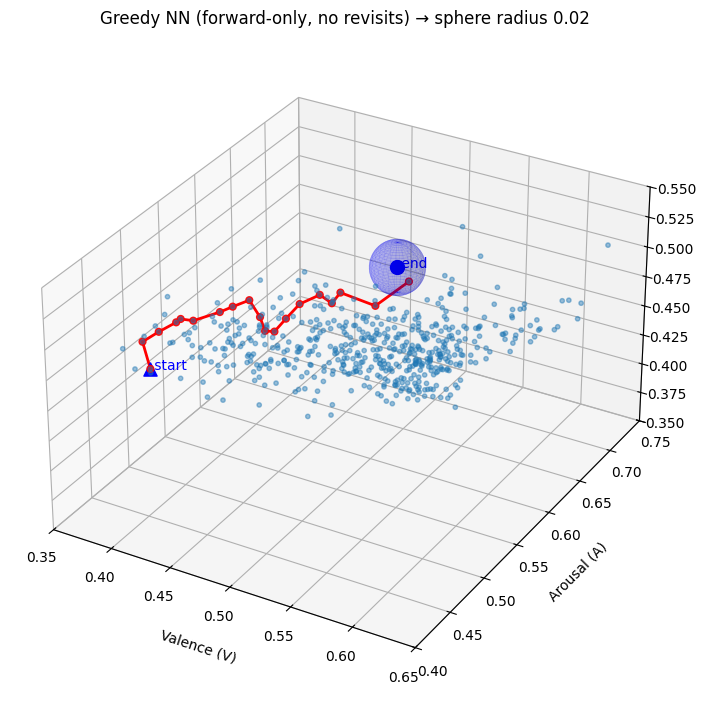

[요약] 시작 index: 188
[요약] 방문 노드 수: 19
[요약] 타깃(구) 도달 여부: False 
[요약] 마지막 노드-구 중심 거리: 0.0270
[요약] 전진 가능한 미방문 후보가 없어 중단(뒤로 가지 않기 규칙에 의해 차단됨).

[경로 지표]
- 평균 스텝 크기: 0.0166
- 최대 스텝 크기: 0.0308
- 스텝 크기 표준편차: 0.0058
- 평균 곡률: 0.9982 rad  (57.1937°)
- 방향성 효율(평균 진행량; 타깃 방향 투영): 0.0111
- 방향 정렬도 평균(cos): 0.6815  [-1~1]

[경로 노드 (title - artist @ V,A,D)]
 1. 너에게로 또 다시 - 이소라  (V=0.388, A=0.476, D=0.458)
 2. 하루 - 김범수  (V=0.378, A=0.481, D=0.475)
 3. Loveship - 폴킴  (V=0.384, A=0.494, D=0.478)
 4. 나야 나 (PICK ME) - PRODUCE 101  (V=0.393, A=0.504, D=0.484)
 5. 무지개 - Cho Kyu Chan  (V=0.405, A=0.491, D=0.496)
 6. 제발 - 김범수  (V=0.416, A=0.491, D=0.498)
 7. 기억해...사랑해... - 플라워  (V=0.430, A=0.505, D=0.502)
 8. 이별이 오지 못하게 - 페이지  (V=0.436, A=0.513, D=0.504)
 9. 그녀를 사랑해줘요 - 하동균  (V=0.450, A=0.512, D=0.514)
10. 그때 그 아인 - 김필  (V=0.456, A=0.518, D=0.499)
11. 그라데이션 - 10CM  (V=0.464, A=0.511, D=0.493)
12. 나의 하루 - 이소라  (V=0.471, A=0.512, D=0.495)
13. Who Are You - 샘김 (Sam Kim)  (V=0.476, A=0.519, D=0.503)
14. Sing For You - 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ===================== 사용자 설정 =====================
start_node   = (0.4, 0.4, 0.37)   # 시작 좌표(스냅)
START_INDEX  = None                   # 인덱스로 시작하고 싶으면 숫자, 아니면 None

end_node     = (0.55, 0.55, 0.55)    # 목표 좌표(구 중심도 이 좌표로)
END_INDEX    = None                   # 인덱스로 지정하고 싶으면 숫자, 아니면 None

SPHERE_RADIUS = 0.02      # 구 반경
SPHERE_ALPHA  = 0.15      # 구 투명도(0~1)
POINT_SIZE    = 10
SAVE_FIG_PATH = None

MIN_FORWARD_DELTA = 0.0
EPS = 1e-12

# ==== 축 범위(원하면 수정, 자동이면 None) ====
AX_V_LIM = (0.35, 0.65)   # 예: (0.35, 0.65) / None이면 자동(0~1)
AX_A_LIM = (0.40, 0.75)
AX_D_LIM = (0.35, 0.55)
# =======================================================

# ========== 유틸: VAD/메타 컬럼 찾기 & 전처리 ==========
def find_vad_columns(df):
    cand = {"V":["v","val","valence"], "A":["a","aro","arousal"], "D":["d","dom","dominance"]}
    found = {}
    for k, names in cand.items():
        hit = None
        for name in names:
            exact  = [c for c in df.columns if str(c).lower()==name]
            starts = [c for c in df.columns if str(c).lower().startswith(name)]
            if exact:  hit = exact[0]; break
            if starts: hit = starts[0]; break
        if hit is None:
            raise ValueError(f"'{k}' 컬럼을 찾지 못했습니다. df.columns={list(df.columns)}")
        found[k] = hit
    return found["V"], found["A"], found["D"]

def find_meta_column(df, candidates):
    cols_lower = {str(c).lower(): c for c in df.columns}
    for name in candidates:
        if name in cols_lower:
            return cols_lower[name]
        for k, orig in cols_lower.items():
            if k.startswith(name):
                return orig
    return None

def prepare_X_and_df(df):
    """
    X(수치행렬)와 결측 제거된 df_clean, 그리고 V/A/D 원본 컬럼명을 함께 반환.
    """
    v,a,d = find_vad_columns(df)
    X_raw = df[[v,a,d]].apply(pd.to_numeric, errors="coerce").to_numpy()
    mask = np.all(np.isfinite(X_raw), axis=1)
    if not mask.all():
        print(f"[정보] NaN/inf 포함 행 {mask.size - mask.sum()}개 제거")
    df_clean = df.loc[mask].reset_index(drop=True)
    X = X_raw[mask]
    if X.shape[0] < 2:
        raise ValueError("최소 2개 이상의 노드가 필요합니다.")
    return X, df_clean, v, a, d

def pick_index_by_coord(X, coord):
    q = np.asarray(coord, dtype=float).reshape(1,-1)
    return int(np.argmin(np.linalg.norm(X - q, axis=1)))

def resolve_start_end(X, start_node=None, start_index=None, end_node=None, end_index=None):
    # 시작 인덱스(설정 좌표에 가장 가까운 노드로 스냅)
    if start_node is not None:
        s = pick_index_by_coord(X, start_node)
    elif start_index is not None:
        if not (0 <= start_index < X.shape[0]): raise ValueError("START_INDEX 범위 오류")
        s = int(start_index)
    else:
        s = 0  # 기본값

    # 구 중심 좌표: 사용자가 준 end_node 좌표 그대로(= 스냅 아님)
    if end_node is not None:
        t_center = np.asarray(end_node, dtype=float).reshape(-1)
    elif end_index is not None:
        if not (0 <= end_index < X.shape[0]): raise ValueError("END_INDEX 범위 오류")
        t_center = X[int(end_index)]
    else:
        raise ValueError("end_node 또는 END_INDEX 중 하나는 반드시 지정하세요.")
    return s, t_center

# ------ 경로 생성: 재방문 금지 + 뒤로 가지 않음 + '구' 도달 시 즉시 종료 ------
def nn_greedy_forward_only_no_revisit(X, start_idx, target_center, sphere_radius=0.3, min_forward_delta=0.0):
    """
    1) 미방문 후보 중,
    2) 타깃까지 거리가 현재보다 min_forward_delta만큼 작거나 같은 점만 허용,
    3) 그중 현재에서 가장 가까운 점으로 이동.
    종료: ||X[i] - target_center|| <= sphere_radius  (목표 '구'에 들어가면 즉시 종료)
    """
    def in_sphere(i):
        return np.linalg.norm(X[i] - target_center) <= sphere_radius

    n = X.shape[0]
    cur = int(start_idx)
    visited = {cur}
    path = [cur]

    # 시작점이 이미 구 안이면 즉시 종료
    if in_sphere(cur):
        return path, True, cur, {"blocked": False}

    dist_to_target = np.linalg.norm(X - target_center, axis=1)

    while True:
        cur_to_target = dist_to_target[cur]
        d_from_cur = np.linalg.norm(X - X[cur], axis=1)

        cand_mask = np.ones(n, dtype=bool)
        cand_mask[list(visited)] = False
        forward_mask = dist_to_target <= (cur_to_target - min_forward_delta)
        allowed = cand_mask & forward_mask

        if not np.any(allowed):
            return path, False, None, {"blocked": True}

        cand_idx = np.where(allowed)[0]
        nxt = int(cand_idx[np.argmin(d_from_cur[cand_idx])])

        cur = nxt
        visited.add(cur)
        path.append(cur)

        # 이동 직후 구에 들어갔는지 판정 → 들어가면 즉시 종료
        if in_sphere(cur):
            return path, True, cur, {"blocked": False}

# -------- 축 범위/등축 적용 --------
def apply_axis_limits(ax, v_lim=None, a_lim=None, d_lim=None):
    # 사용자 설정 반영 (None이면 0~1)
    if v_lim is not None: ax.set_xlim(*v_lim)
    else:                 ax.set_xlim(0, 1)
    if a_lim is not None: ax.set_ylim(*a_lim)
    else:                 ax.set_ylim(0, 1)
    if d_lim is not None: ax.set_zlim(*d_lim)
    else:                 ax.set_zlim(0, 1)

    # 데이터 단위가 등축으로 보이게 비율 맞춤(구가 타원처럼 보이지 않도록)
    xr = abs(ax.get_xlim()[1] - ax.get_xlim()[0])
    yr = abs(ax.get_ylim()[1] - ax.get_ylim()[0])
    zr = abs(ax.get_zlim()[1] - ax.get_zlim()[0])
    ax.set_box_aspect((xr, yr, zr))

# -------- 정확한 '구' 렌더링 --------
def plot_sphere(ax, center, radius, res_u=60, res_v=30, color='blue', alpha=0.15, wire=True, wire_alpha=0.12):
    # x = cx + r*cos(u)*sin(v), y = cy + r*sin(u)*sin(v), z = cz + r*cos(v)
    u, v = np.mgrid[0:2*np.pi:complex(res_u), 0:np.pi:complex(res_v)]
    x = center[0] + radius * np.cos(u) * np.sin(v)
    y = center[1] + radius * np.sin(u) * np.sin(v)
    z = center[2] + radius * np.cos(v)
    ax.plot_surface(x, y, z, color=color, alpha=alpha, linewidth=0, antialiased=True)
    if wire:
        ax.plot_wireframe(x, y, z, color=color, alpha=wire_alpha, linewidth=0.4)

# -------- 시각화 (색상 동일 유지) --------
def plot_vad_with_path_sphere(
    X, path, start_idx, end_center, sphere_radius,
    reached=False, reach_idx=None, save_path=None,
    v_lim=None, a_lim=None, d_lim=None
):
    V,A,D = X[:,0], X[:,1], X[:,2]
    P = X[path]

    fig = plt.figure(figsize=(8,7), constrained_layout=True)
    ax = fig.add_subplot(111, projection="3d")

    # 전체 노드(옅게, 기본색)
    ax.scatter(V, A, D, s=POINT_SIZE, alpha=0.45)

    # 경로(빨강)
    ax.plot(P[:,0], P[:,1], P[:,2], c="red", linewidth=2)
    ax.scatter(P[:,0], P[:,1], P[:,2], s=24, c="red", alpha=0.9)

    # 시작/목표 표시(파랑)
    ax.scatter(X[start_idx,0], X[start_idx,1], X[start_idx,2], s=90, c="blue", marker="^")
    ax.text(X[start_idx,0], X[start_idx,1], X[start_idx,2], " start", color="blue")
    ax.scatter(end_center[0], end_center[1], end_center[2], s=100, c="blue")
    ax.text(end_center[0], end_center[1], end_center[2], " end", color="blue")

    # 목표 '구'
    plot_sphere(ax, center=end_center, radius=sphere_radius,
                color='blue', alpha=SPHERE_ALPHA, wire=True, wire_alpha=0.12)

    if reached and reach_idx is not None:
        ax.scatter(X[reach_idx,0], X[reach_idx,1], X[reach_idx,2],
                   s=130, facecolors="none", edgecolors="red", linewidths=2)

    # 축 범위 적용
    apply_axis_limits(ax, v_lim=v_lim, a_lim=a_lim, d_lim=d_lim)

    ax.set_xlabel("Valence (V)", labelpad=10)
    ax.set_ylabel("Arousal (A)", labelpad=10)
    ax.set_zlabel("Dominance (D)", labelpad=16)
    ax.set_title(f"Greedy NN (forward-only, no revisits) → sphere radius {sphere_radius}")

    plt.show()
    if save_path:
        plt.gcf().savefig(save_path, dpi=150, bbox_inches="tight")

# -------- 경로 지표(네가 쓰던 형식 유지) --------
def compute_path_metrics(X, path_idx, target_point, eps=1e-12):
    P = X[path_idx]
    m = len(P)
    if m < 2:
        return {
            "step_len_mean": None, "step_len_max": None, "step_len_std": None,
            "curvature_mean_rad": None, "curvature_mean_deg": None,
            "progress_mean": None, "align_mean": None,
        }

    diffs = np.diff(P, axis=0)
    step_len = np.linalg.norm(diffs, axis=1)

    # 곡률(연속 스텝 각도)
    curv_list = []
    for i in range(len(diffs)-1):
        a = diffs[i]; b = diffs[i+1]
        na = np.linalg.norm(a); nb = np.linalg.norm(b)
        if na < eps or nb < eps:
            continue
        cosang = np.clip(np.dot(a, b)/(na*nb), -1.0, 1.0)
        curv_list.append(np.arccos(cosang))
    curvature_mean_rad = float(np.mean(curv_list)) if curv_list else None
    curvature_mean_deg = float(np.degrees(curvature_mean_rad)) if curvature_mean_rad is not None else None

    # 방향성 효율
    progress_vals, align_vals = [], []
    for i in range(m-1):
        vt = P[i+1] - P[i]
        ut = target_point - P[i]
        nu = np.linalg.norm(ut)
        nv = np.linalg.norm(vt)
        if nu < eps:
            continue
        uhat = ut / nu
        progress_vals.append(float(np.dot(vt, uhat)))      # 타깃방향 진행량
        if nv > eps:
            align_vals.append(float(np.dot(vt/nv, uhat)))  # 정렬도 cos
    progress_mean = float(np.mean(progress_vals)) if progress_vals else None
    align_mean    = float(np.mean(align_vals)) if align_vals else None

    return {
        "step_len_mean": float(np.mean(step_len)),
        "step_len_max":  float(np.max(step_len)),
        "step_len_std":  float(np.std(step_len)),
        "curvature_mean_rad": curvature_mean_rad,
        "curvature_mean_deg": curvature_mean_deg,
        "progress_mean": progress_mean,
        "align_mean": align_mean,
    }

# ===================== 실행부 =====================
# ※ df는 이미 로드되어 있다고 가정 (예: df = pd.read_csv("VAD_song.csv"); df.columns=[c.strip() for c in df.columns])
X, df_clean, vcol, acol, dcol = prepare_X_and_df(df)

# 메타 컬럼 자동 탐색 (title/artist)
title_col  = find_meta_column(df_clean, ["title","곡명","track","song","name"])
artist_col = find_meta_column(df_clean, ["artist","가수","singer","performer","artist_name"])

# 시작/목표 해석 (시작은 스냅된 가장 가까운 노드에서 출발, 구 중심은 end_node 좌표)
start_idx, end_center = resolve_start_end(
    X, start_node=start_node, start_index=START_INDEX,
    end_node=end_node, end_index=END_INDEX
)

# 경로 생성 (구 내부 진입 시 즉시 종료)
path, reached, reach_idx, info = nn_greedy_forward_only_no_revisit(
    X, start_idx=start_idx, target_center=end_center,
    sphere_radius=SPHERE_RADIUS, min_forward_delta=MIN_FORWARD_DELTA
)

# 시각화 (색상 유지 + 사용자 축 범위 적용 + 정확한 구)
plot_vad_with_path_sphere(
    X, path=path, start_idx=start_idx, end_center=end_center,
    sphere_radius=SPHERE_RADIUS, reached=reached, reach_idx=reach_idx,
    save_path=SAVE_FIG_PATH, v_lim=AX_V_LIM, a_lim=AX_A_LIM, d_lim=AX_D_LIM
)

# 요약
last_idx = path[-1]
dist_last_to_target = np.linalg.norm(X[last_idx] - end_center)
print(f"[요약] 시작 index: {start_idx}")
print(f"[요약] 방문 노드 수: {len(path)}")
print(f"[요약] 타깃(구) 도달 여부: {reached} " + (f"(도달 index: {reach_idx})" if reached else ""))
print(f"[요약] 마지막 노드-구 중심 거리: {dist_last_to_target:.4f}")
if info.get("blocked", False):
    print("[요약] 전진 가능한 미방문 후보가 없어 중단(뒤로 가지 않기 규칙에 의해 차단됨).")

# 경로 지표
metrics = compute_path_metrics(X, path, target_point=end_center, eps=EPS)
def _fmt(x, nd=4): return "N/A" if x is None else f"{x:.{nd}f}"
print("\n[경로 지표]")
print(f"- 평균 스텝 크기: {_fmt(metrics['step_len_mean'])}")
print(f"- 최대 스텝 크기: {_fmt(metrics['step_len_max'])}")
print(f"- 스텝 크기 표준편차: {_fmt(metrics['step_len_std'])}")
print(f"- 평균 곡률: {_fmt(metrics['curvature_mean_rad'])} rad  ({_fmt(metrics['curvature_mean_deg'])}°)")
print(f"- 방향성 효율(평균 진행량; 타깃 방향 투영): {_fmt(metrics['progress_mean'])}")
print(f"- 방향 정렬도 평균(cos): {_fmt(metrics['align_mean'])}  [-1~1]")

# ===== (title, artist) 리스트 출력 =====
def _safe_str(x):
    return "" if (x is None or (isinstance(x, float) and np.isnan(x))) else str(x)

print("\n[경로 노드 (title - artist @ V,A,D)]")
titles_artists = []
for k, idx in enumerate(path, 1):
    row = df_clean.iloc[idx]
    ti = _safe_str(row[title_col])  if (title_col  in df_clean.columns) else ""
    ar = _safe_str(row[artist_col]) if (artist_col in df_clean.columns) else ""
    v, a_, d = float(row[vcol]), float(row[acol]), float(row[dcol])
    titles_artists.append((ti, ar))
    if ti or ar:
        print(f"{k:2d}. {ti} - {ar}  (V={v:.3f}, A={a_:.3f}, D={d:.3f})")
    else:
        print(f"{k:2d}. (V={v:.3f}, A={a_:.3f}, D={d:.3f})")

print("\n[경로: (title, artist) 리스트]")
for i, (ti, ar) in enumerate(titles_artists, 1):
    print(f"{i:2d}. {ti} - {ar}")